# IQFT with Amplitude encoding (not working) 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import pennylane as qml
from pennylane import numpy as pnp

import warnings
warnings.filterwarnings('ignore')

In [2]:
n = 8
sky_image = np.zeros((n, n), dtype='complex64')
mask = np.zeros((n, n), dtype='bool')
number_of_stars = np.random.randint(1, 7)
radius = 1 

for i in range(0, number_of_stars):
    index_i = np.random.randint(0, sky_image.shape[0]-radius)
    index_j = np.random.randint(0, sky_image.shape[1]-radius)
    for j in range(0, radius):
        for k in range(0, radius):
            sky_image[index_i+j][index_j+k] = complex(np.random.rand()*100, np.random.rand()*100)
            mask[index_i+j][index_j+k] = True
            
sky_image.real += np.random.randn(n,n)/100
sky_image.imag += np.random.randn(n,n)/100

print(sky_image)

[[ 4.02448047e-03-1.13961874e-02j -9.73804947e-03-1.25846674e-03j
  -1.09473628e-03-1.13751495e-03j  9.20645981e+01+6.85633993e+00j
  -5.00453207e-05+3.34006175e-03j -2.72874143e-02+1.19130593e-02j
  -9.28488653e-03+2.07115002e-02j -1.29910689e-02-1.84461381e-02j]
 [ 2.79158149e-02-5.63867576e-03j  1.79598145e-02+1.23829566e-04j
  -1.51008787e-02+3.99554800e-03j -2.00786954e-03-7.95752835e-03j
  -4.13904991e-03-9.37151257e-03j  6.01573801e-03+2.10790262e-02j
   1.54574029e-02+2.05405615e-02j  2.65489263e-03+1.01123406e-02j]
 [ 7.28837820e-03+6.14662655e-03j  1.37857068e-03-6.29813410e-03j
   5.08797355e-03-1.01065682e-03j  8.11647065e-03+4.50322451e-03j
   1.18094049e-02-1.49626965e-02j  3.64741986e-03+1.77679118e-03j
  -5.02551300e-03-2.14190735e-03j  1.65346544e-02+1.48084096e-03j]
 [-7.59349763e-03-1.33695668e-02j -2.20989138e-02-1.11815231e-02j
   8.77721235e-03+5.28133940e-03j  2.15796800e-03+5.24913752e-03j
   9.19566117e-03-1.83306169e-03j  1.72170048e+01+7.25610580e+01j
  -5.96

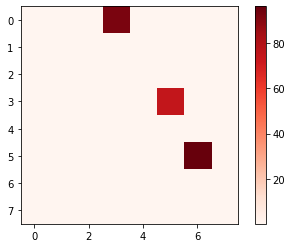

In [3]:
modulus = np.absolute(sky_image)
plt.imshow(modulus, cmap='Reds')
plt.colorbar();

In [4]:
visibilities = np.fft.fft(sky_image.flatten()).astype('complex64')
print(visibilities)

[ 139.5968    +1.7091809e+02j   -0.93813455-8.2879646e+01j
   61.45489   -7.1596123e+01j  201.68256   -1.0046131e+02j
  -62.217754  +4.7366020e+01j   10.527287  -1.7452704e+02j
  -12.695104  -1.5183417e+02j   82.3686    +1.8358644e+01j
 -215.30087   -7.8844948e+01j  -40.279694  -8.9204041e+01j
  -23.9814    -8.5417580e+01j -108.10908   +1.6888583e+02j
 -162.05453   -8.7995964e+01j  -49.040264  +4.4207905e+01j
   56.90402   +9.1197571e+01j -181.39828   +1.7107997e+02j
   35.56509   -1.6703394e+01j   41.444115  +7.3579735e+01j
  108.26482   +2.0237132e+02j  -85.33748   -7.1081910e+00j
  169.44446   +1.6003046e+01j  142.63477   +4.7532010e+00j
   21.405304  +1.2621103e+02j   56.096996  -1.9334515e+02j
  122.2796    -2.6862923e+01j  117.20361   -3.1738480e+01j
 -139.4049    -6.5057739e+01j   97.45083   -1.9523181e+02j
  -16.412413  -5.6090832e+01j  -45.48729   +3.3220585e+01j
 -190.36365   -1.8055328e+02j   35.253265  -1.6274960e+01j
  -79.11154   +1.2013228e+01j -190.24947   +1.0627372e+0

In [5]:
sanity = np.fft.ifft(visibilities).astype('complex64')
sanity = np.array(sanity).reshape(sky_image.shape[0] , sky_image.shape[1])

test1_real = ((sky_image.real - sanity.real)**2).mean()
test1_imag = ((sky_image.imag - sanity.imag)**2).mean()
 
print('Reals MSE: '+ str(test1_real))
print('Imaginaries MSE: '+ str(test1_imag))

Reals MSE: 1.3288368e-13
Imaginaries MSE: 9.795797e-14


Wires: range(0, 6)


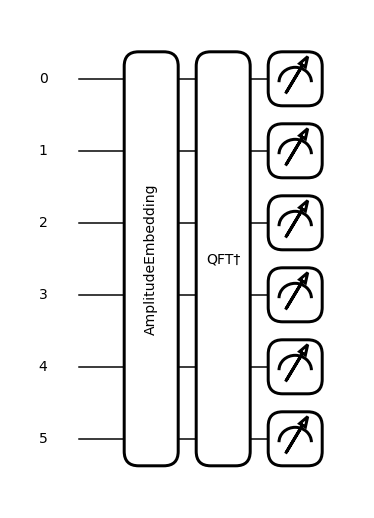

In [6]:
n_n = n*n
inp = visibilities

norm = qml.math.sum(qml.math.abs(inp) ** 2)
#normalized_data = data / qml.math.sqrt(norm)

wires = range(math.ceil(math.log2(n_n)))
print( 'Wires: ' + str(wires) )
amp_dev = qml.device('default.qubit', wires)


@qml.qnode(amp_dev)
def amp_encoding(data):
    qml.AmplitudeEmbedding(data, wires, normalize=True, pad_with=0.)
    qml.adjoint(qml.QFT)(wires=wires) #inverting the QFT
    return qml.state()

readout = amp_encoding(inp).astype('complex64')
qml.draw_mpl(amp_encoding)(inp)

readout.numpy()
readout = readout*qml.math.sqrt(norm)
readout.real = readout.real/2**64
readout = readout[:n_n]
readout = np.array(readout).reshape(sky_image.shape[0] , sky_image.shape[1])

In [7]:
fidelity = readout

test2_real = ((sky_image.real - fidelity.real)**2).mean()
test2_imag = ((sky_image.imag - fidelity.imag)**2).mean()

print('Reals MSE: '+ str(test2_real))
print('Imaginaries MSE: '+ str(test2_imag))

Reals MSE: 151.32999
Imaginaries MSE: 13899.105


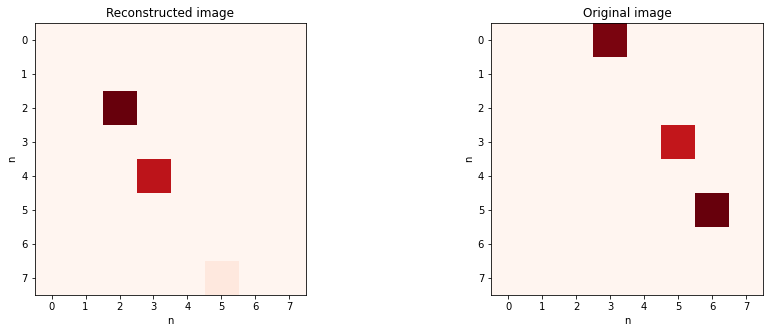

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
modulus1 = np.absolute(fidelity)
modulus2 = np.absolute(sky_image)

axs[0].imshow(modulus1, cmap='Reds')
axs[1].imshow(modulus2, cmap='Reds')

axs[0].set_title("Reconstructed image")
axs[1].set_title("Original image")

for ax in axs.flat:
    ax.set(xlabel='n', ylabel='n')
plt.savefig('plot4.jpg', dpi=100)
plt.show()